In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
sns.set_style("whitegrid")
sns.set_context("paper")
import altair as alt
alt.data_transformers.disable_max_rows()
alt.__version__

'5.1.1'

In [3]:
# combine files from list
data = []
for csv in ['daytime_UHI_2020.csv','nighttime_UHI_2020.csv','summerdaytime_UHI_2020.csv','summernighttime_UHI_2020.csv','winterdaytime_UHI_2020.csv','winternighttime_UHI_2020.csv']:
    frame = pd.read_csv(csv)
    frame['file'] = os.path.splitext(csv)[0]
    data.append(frame)
df = pd.concat(data, ignore_index=True)

In [4]:
#dictionary of col names
map_dict = {"class_0":"open_space",
  "class_1":"nonresidential",
  "class_2":"atomistic",
  "class_3":"informal_subdivision",
  "class_4":"formal_subdivision",
  "class_5":"housing_project",
  "class_6":"road"}

In [5]:
#df.fillna(0, inplace=True)
df.fillna(1e-8, inplace=True)


In [6]:
# create groupby function
def uh_df_create(csvname, groups=['country_iso3', 'region']):
    df = pd.read_csv(csvname)
    df.fillna(1e-8, inplace=True)
    d = df.groupby(groups).apply(lambda x: np.average(x['mean_0'], weights=x['count_0'])).to_frame()
    d.rename(columns={0: 'class_0'}, inplace=True)
    for i in [1,2,3,4,5]:
        d[f'class_{i}'] = df.groupby(groups).apply(lambda x: np.ma.average(x[f'mean_{i}'], weights=x[f'count_{i}'])).values
    df2 = d.stack().to_frame().reset_index()
    df2.rename(columns={0: 'val', 'level_2':'class','level_1':'class'}, inplace=True)
    df2['file'] = csvname
    return df2

In [7]:
#create dataframes of selected groupbys
uhdf_country = pd.concat([uh_df_create(i) for i in ['daytime_UHI_2020.csv','nighttime_UHI_2020.csv','summerdaytime_UHI_2020.csv','summernighttime_UHI_2020.csv','winterdaytime_UHI_2020.csv','winternighttime_UHI_2020.csv']])
uhdf_country.reset_index(inplace=True,drop=True)
uhdf_region = pd.concat([uh_df_create(i, groups=['region']) for i in ['daytime_UHI_2020.csv','nighttime_UHI_2020.csv','summerdaytime_UHI_2020.csv','summernighttime_UHI_2020.csv','winterdaytime_UHI_2020.csv','winternighttime_UHI_2020.csv']])
uhdf_region.reset_index(inplace=True,drop=True)
uhdf_country['class'] = uhdf_country['class'].map(map_dict)
uhdf_region['class'] = uhdf_region['class'].map(map_dict)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/ma/extras.py:649: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/ma/extras.py:649: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/ma/extras.py:649: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/ma/extras.py:649: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/ma/extras.py:649: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/ma/extras.py:649: RuntimeWarning: inva

In [8]:
#cleanup
d = df.groupby(['file']).apply(lambda x: np.average(x['mean_0'], weights=x['count_0'])).to_frame()
d.rename(columns={0: 'class_0'}, inplace=True)
for i in [1,2,3,4,5]:
    d[f'class_{i}'] = df.groupby(['file']).apply(lambda x: np.ma.average(x[f'mean_{i}'], weights=x[f'count_{i}'])).values
df2 = d.stack().to_frame().reset_index()
df2.rename(columns={0: 'val', 'level_2':'class','level_1':'class'}, inplace=True)
df2['class'] = df2['class'].map(map_dict)

In [9]:
#trellis plot selection
selection = alt.selection_point(fields=['file'], bind='legend')

alt.Chart(df2).mark_point().encode(
    alt.X('val'),
    alt.Y('class'),
    alt.Color('file'),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_params(
    selection
)

alt.Chart(...)

In [10]:
alt.Chart(df2[df2.file.isin(['summerdaytime_UHI_2020','winterdaytime_UHI_2020'])]).mark_point().encode(
    alt.X('val'),
    alt.Y('class'),
    alt.Color('file')
)

alt.Chart(...)

In [11]:
alt.Chart(df2[df2.file.isin(['summernighttime_UHI_2020','winternighttime_UHI_2020'])]).mark_point().encode(
    alt.X('val'),
    alt.Y('class'),
    alt.Color('file')
)

alt.Chart(...)

In [12]:
alt.Chart(
    uhdf_country,
    width=100,
    height=80
).transform_density(
    'val',
    groupby=['class','file'],
    as_=['val', 'density'],
    extent=[-2, 5],
    bandwidth=0.2
).mark_area().encode(
    x="val:Q",
    y='density:Q',
).facet(
    row='class:N',
    column='file:N'
)

alt.FacetChart(...)

In [13]:
g = uhdf_country.loc[uhdf_country.file.isin(['daytime_UHI_2020.csv','nighttime_UHI_2020.csv'])]
step = 20
overlap = 1

alt.Chart(
    g,
    width=100,
    height=step
).transform_density(
    'val',
    groupby=['class','file'],
    as_=['val', 'density'],
    extent=[-2, 5],
    bandwidth=0.3
).mark_area().encode(
    alt.X("val:Q"),
    #y='density:Q',
    alt.Y('density:Q')
        .axis(None)
        .scale(range=[step, -step * overlap]),
    alt.Fill('mean(val)')
        .legend(None)
        .scale(domain=[2, 0], scheme='redyellowblue')
).facet(
    row='class:N',
    column='file:N'
    #row =alt.Row('class:N')
     #   .title(None)
      #  .header(labelAngle=0, labelAlign='left', format='%B')
).properties(
    bounds='flush',
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

alt.FacetChart(...)

In [26]:
g = uhdf_country.loc[uhdf_country.file.isin(['daytime_UHI_2020.csv'])] #'nighttime_UHI_2020.csv''daytime_UHI_2020.csv'
step = 20
overlap = 1

alt.Chart(g, height=step).transform_joinaggregate(
    mean_val='mean(val)', groupby=['class']
).transform_bin(
    ['bin_max', 'bin_min'], 'val'
).transform_aggregate(
    value='count()', groupby=['class', 'mean_val', 'bin_min', 'bin_max']
).transform_impute(
    impute='value', groupby=['class', 'mean_val'], key='bin_min', value=0
).mark_area(
    interpolate='monotone',
    fillOpacity=0.8,
    stroke='lightgray',
    strokeWidth=0.5
).encode(
    alt.X('bin_min:Q')
        .bin('binned')
        .title('UHI Temperature (C)'),
    alt.Y('value:Q')
        .axis(None)
        .scale(range=[step, -step * overlap]),
    alt.Fill('mean_val:Q')
        .legend(None)
        .scale(scheme='goldred')
).facet(
    row=alt.Row('class:N',sort=alt.EncodingSortField('val', op='median', order='descending'))
        .title(None)
        .header(labelAngle=0, labelAlign='left'),
    #sort=alt.EncodingSortField('val', op='mean', order='descending')
).properties(
    title='UHI',
    bounds='flush'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).configure_title(
    anchor='end'
)

alt.FacetChart(...)

In [16]:
selection = alt.selection_point(fields=['file'], bind='legend')

alt.Chart(uhdf_region).mark_point().encode(
    alt.X('val'),
    alt.Y('class'),
    alt.Color('file'),
    alt.Row('region'),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_params(
    selection
)

alt.Chart(...)

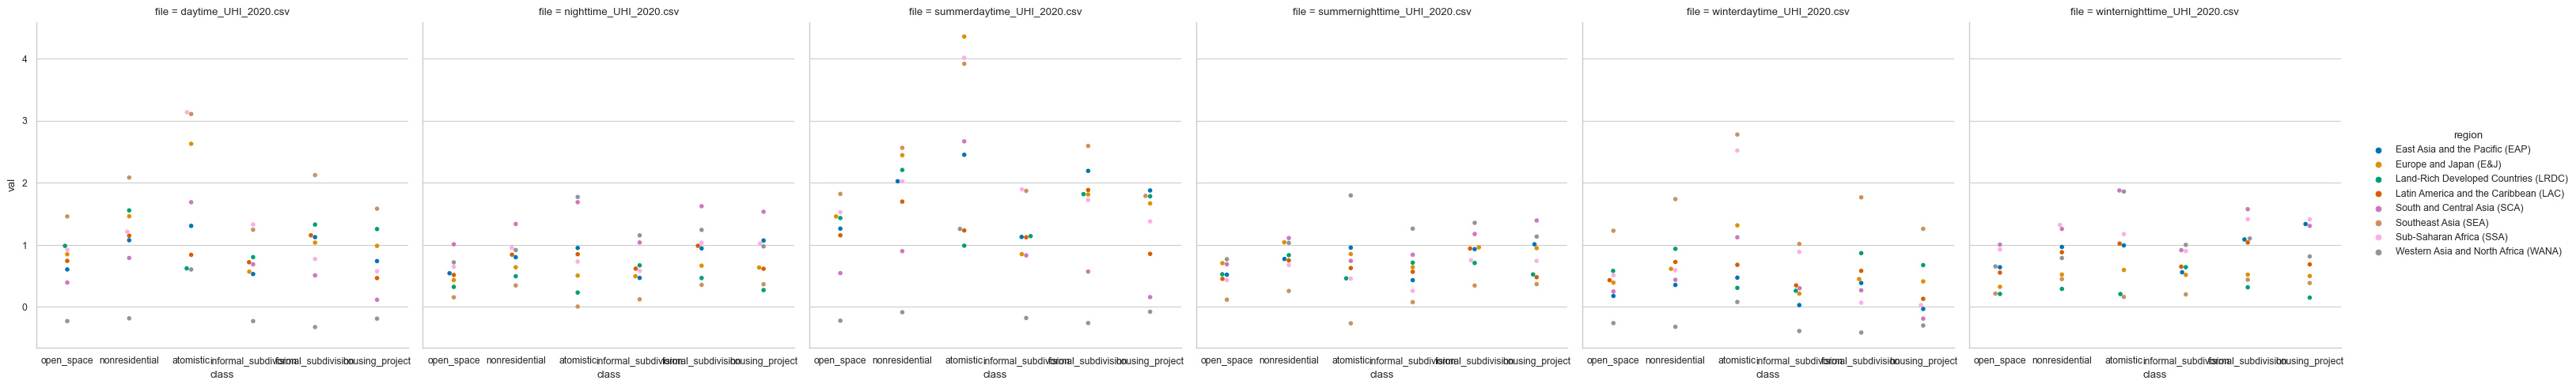

In [17]:
sns.catplot(data=uhdf_region, kind="swarm", 
            x='class', y='val', hue='region',
            col='file', size=4,palette='colorblind')

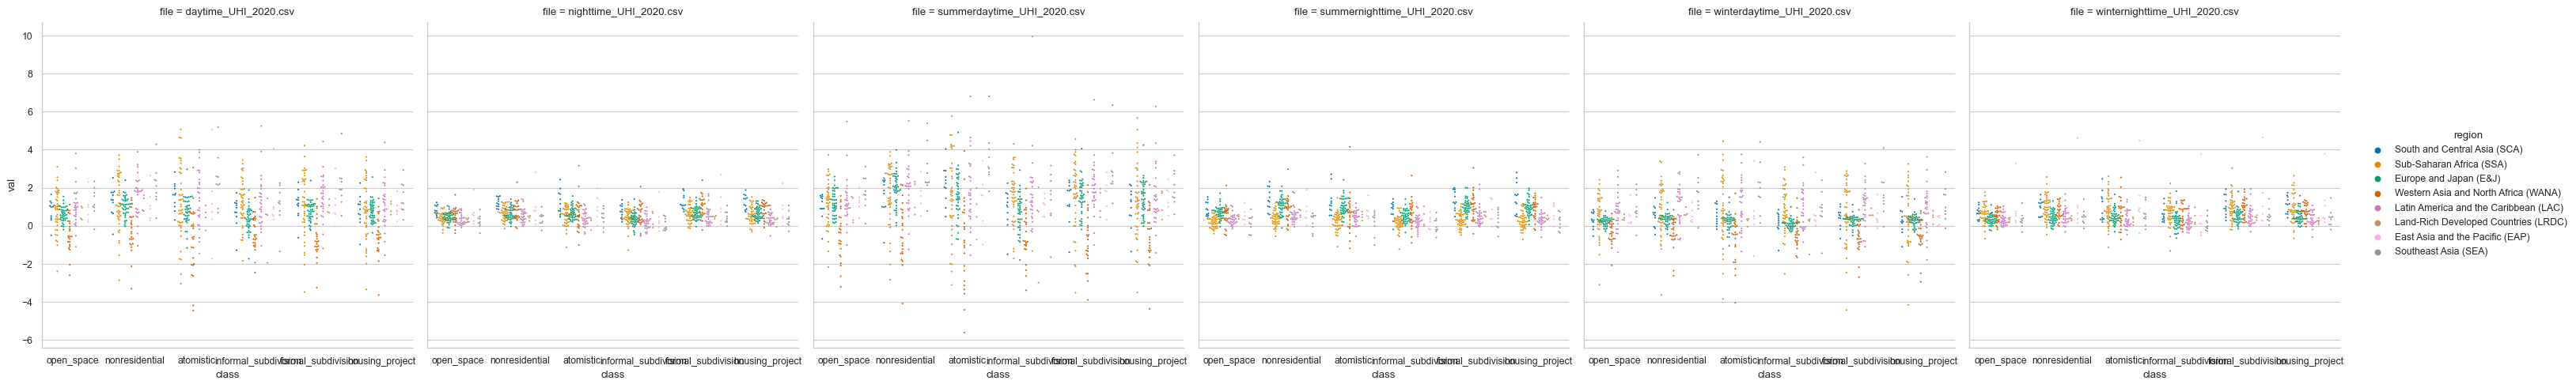

In [18]:
sns.catplot(data=uhdf_country, kind="swarm", 
            x='class', y='val', hue='region',
            col='file', size=1.5,palette='colorblind', dodge=True)

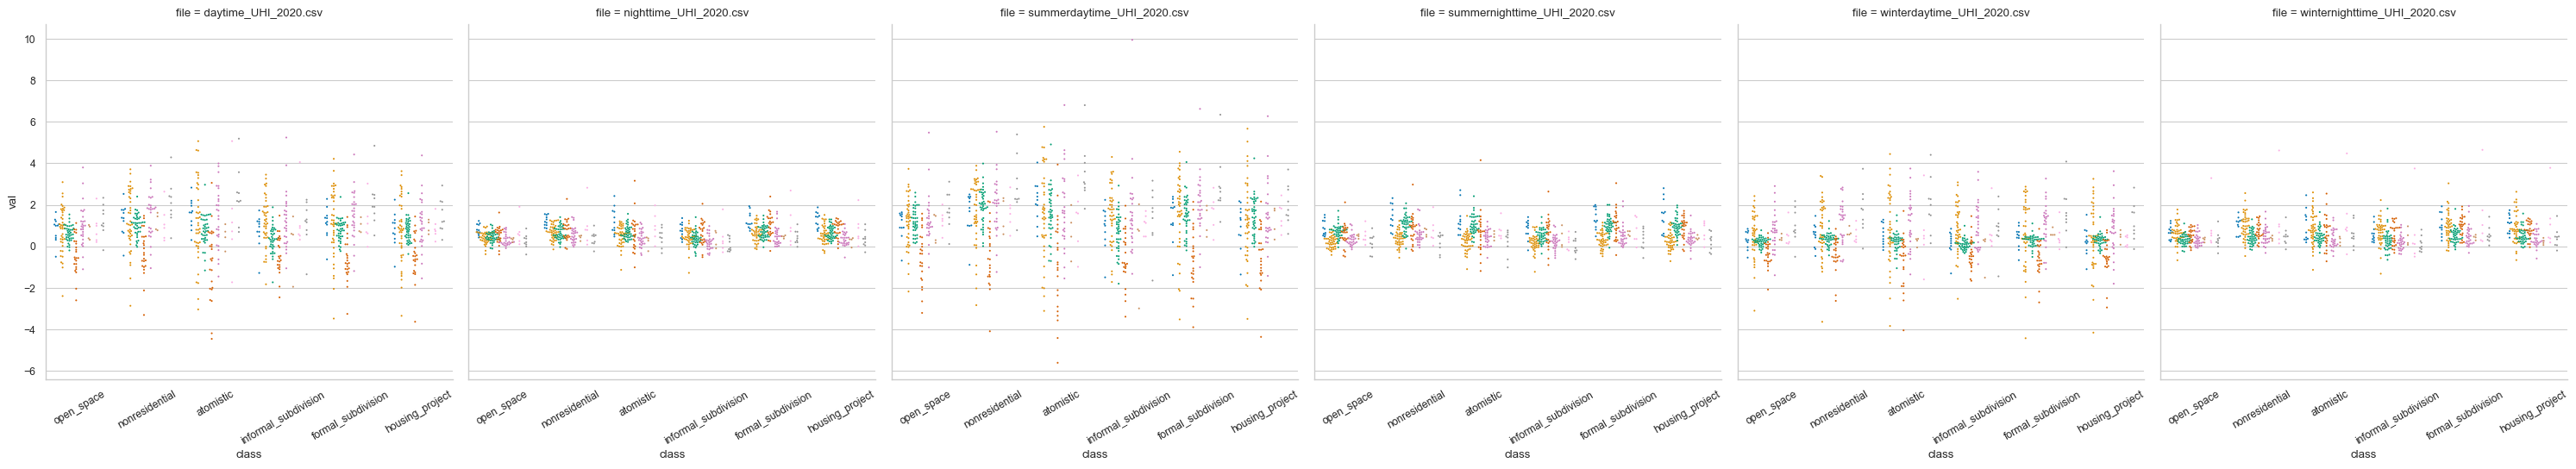

In [19]:
g = sns.catplot(data=uhdf_country, kind="swarm", 
            x='class', y='val', hue='region',
            col='file', size=1.5,palette='colorblind', dodge=True, legend=False)
g.set_xticklabels(rotation=30)

In [31]:
uhdf_country

,country_iso3,region,class,val,file
0,AFG,South and Central Asia (SCA),open_space,0.404156,daytime_UHI_2020.csv
1,AFG,South and Central Asia (SCA),nonresidential,1.220940,daytime_UHI_2020.csv
2,AFG,South and Central Asia (SCA),atomistic,1.011437,daytime_UHI_2020.csv
3,AFG,South and Central Asia (SCA),informal_subdivision,1.079836,daytime_UHI_2020.csv
4,AFG,South and Central Asia (SCA),formal_subdivision,1.181783,daytime_UHI_2020.csv
...,...,...,...,...,...
5779,ZWE,Sub-Saharan Africa (SSA),nonresidential,1.243433,winternighttime_UHI_2020.csv
5780,ZWE,Sub-Saharan Africa (SSA),atomistic,0.662760,winternighttime_UHI_2020.csv
5781,ZWE,Sub-Saharan Africa (SSA),informal_subdivision,1.013213,winternighttime_UHI_2020.csv
5782,ZWE,Sub-Saharan Africa (SSA),formal_subdivision,0.748469,winternighttime_UHI_2020.csv


In [40]:
# order = uhdf_country.groupby("class")["val"].median().sort_values().index
# sns.boxplot(data=uhdf_country,x='val',y='class', order=order)

<AxesSubplot: xlabel='val', ylabel='class'>

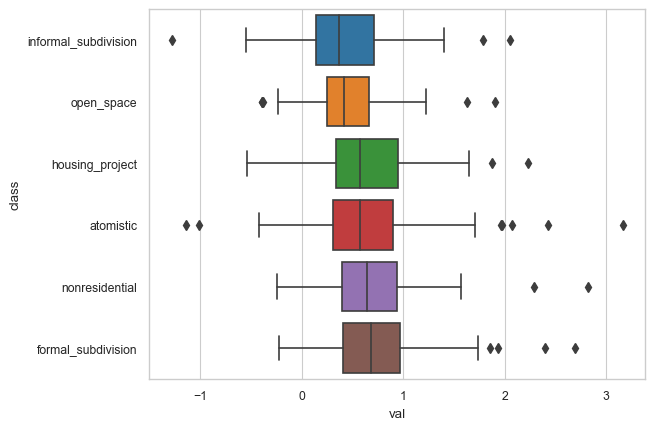

In [43]:
g = uhdf_country.loc[uhdf_country["file"] == 'nighttime_UHI_2020.csv'] #nighttime_UHI_2020 daytime_UHI_2020
order = g.groupby("class")["val"].median().sort_values().index
sns.boxplot(data=g,x='val',y='class', order=order)



<AxesSubplot: xlabel='val', ylabel='class'>

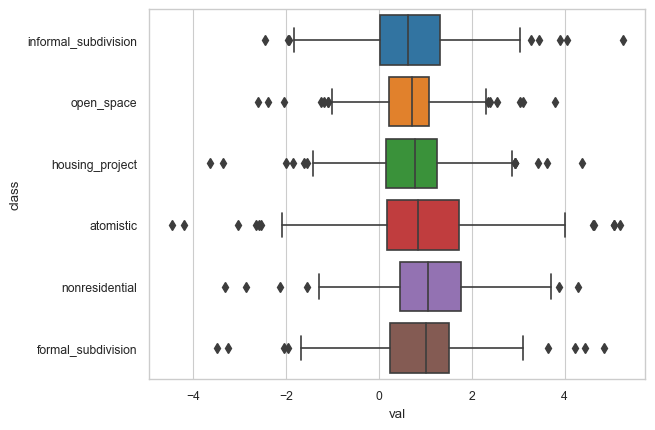

In [44]:
g = uhdf_country.loc[uhdf_country["file"] == 'daytime_UHI_2020.csv'] #nighttime_UHI_2020 daytime_UHI_2020
sns.boxplot(data=g,x='val',y='class', order=order)

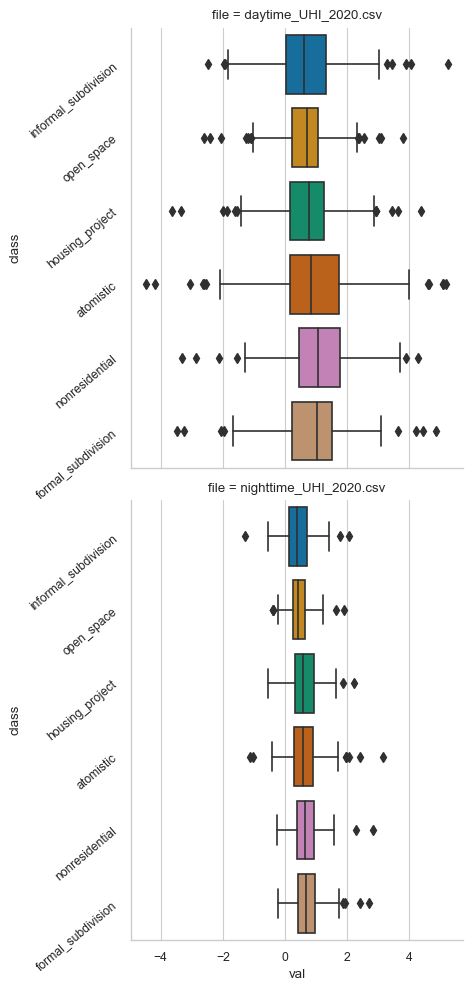

In [51]:
g = uhdf_country.loc[uhdf_country["file"] == 'nighttime_UHI_2020.csv'] #nighttime_UHI_2020 daytime_UHI_2020
order = g.groupby("class")["val"].median().sort_values().index
d = uhdf_country.loc[uhdf_country["file"].isin(['daytime_UHI_2020.csv','nighttime_UHI_2020.csv'])]

g = sns.catplot(data=d, kind="box", 
            x='val', y='class',
            row='file',palette='colorblind', order=order, dodge=True)#, legend=False)
g.set_yticklabels(rotation=40)

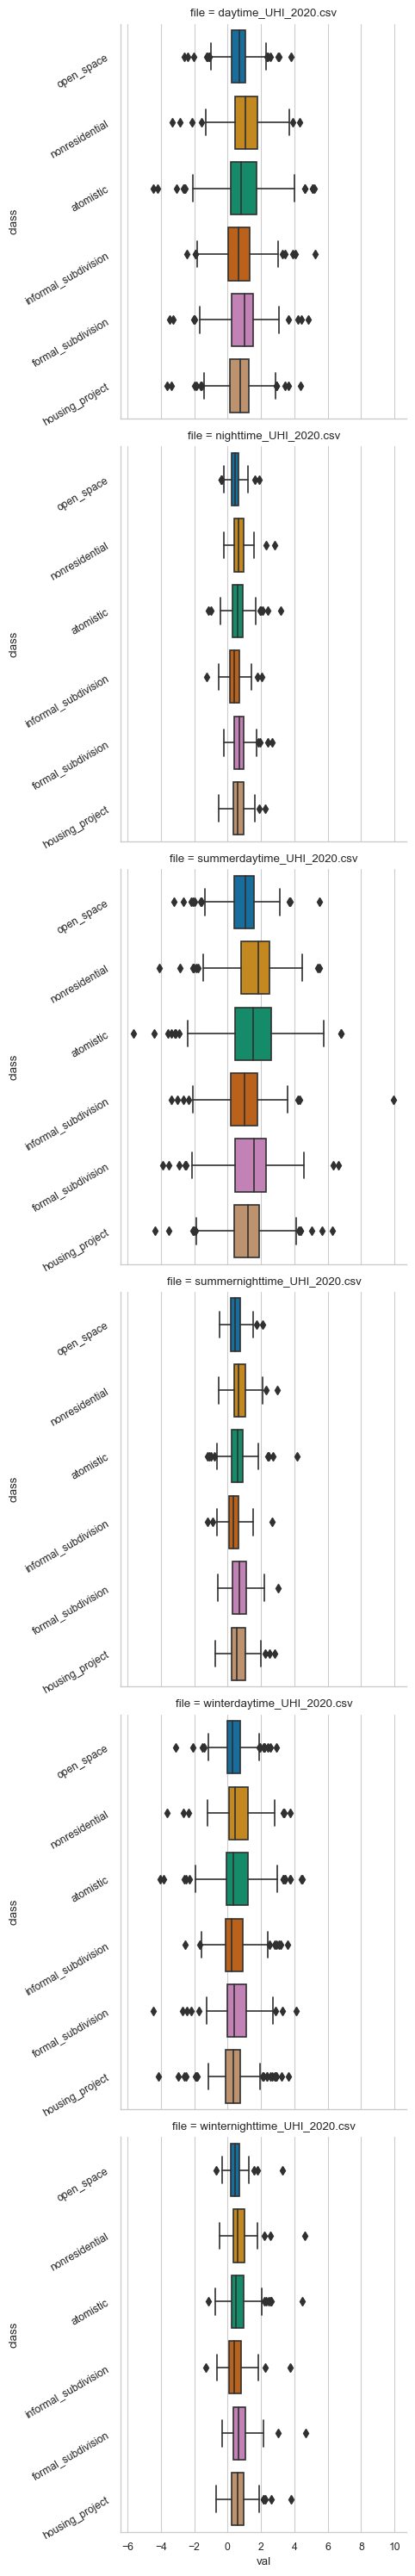

In [49]:
g = sns.catplot(data=uhdf_country, kind="box", 
            x='val', y='class',
            row='file',palette='colorblind', dodge=True)#, legend=False)
g.set_yticklabels(rotation=30)

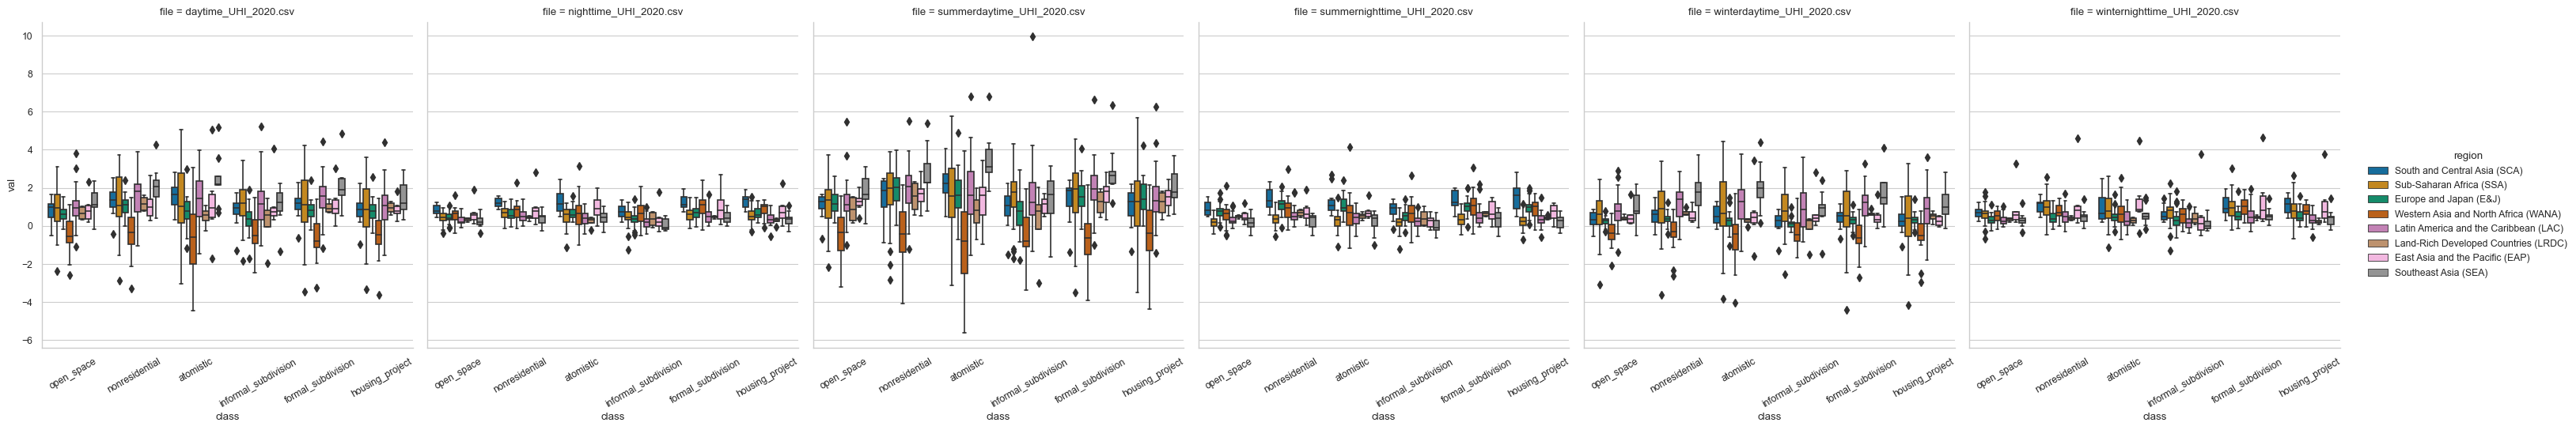

In [21]:
g = sns.catplot(data=uhdf_country, kind="box", 
            x='class', y='val', hue='region',
            col='file',palette='colorblind', dodge=True)#, legend=False)
g.set_xticklabels(rotation=30)

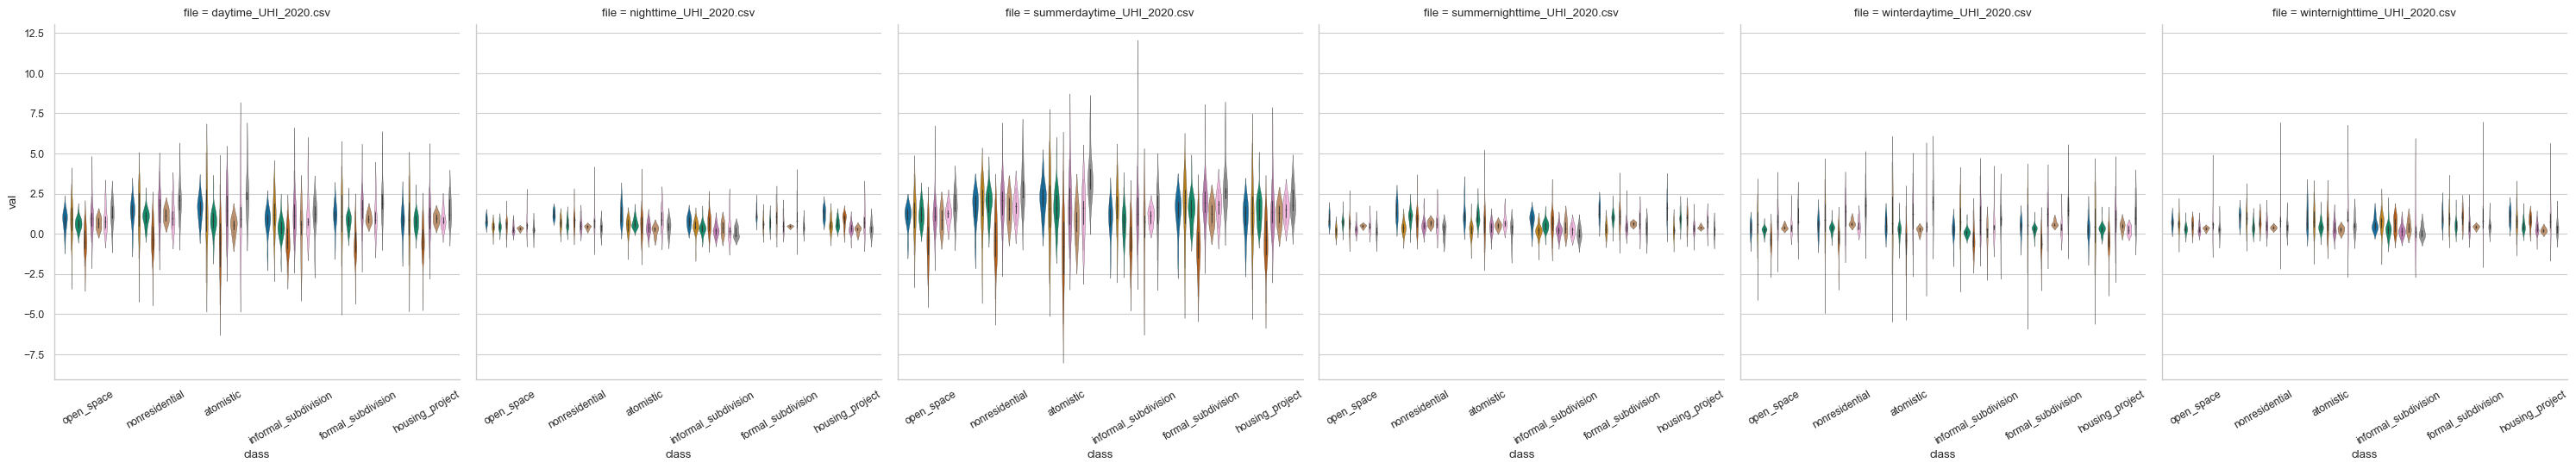

In [23]:
g = sns.catplot(data=uhdf_country, kind="violin", 
            x='class', y='val', hue='region',
            col='file',palette='colorblind', dodge=True, legend=False, linewidth=0.2)
g.set_xticklabels(rotation=30)

## Looking at comparison with annual daytime and nighttime UHI from urban classes sampled at 300m 

In [56]:
# create groupby function
def uh_df_create_alt(csvname, groups=['country_iso3', 'region']):
    df = pd.read_csv(csvname)
    df.fillna(1e-8, inplace=True)
    d = df.groupby(groups).apply(lambda x: np.average(x['mean_0'], weights=x['count_0'])).to_frame()
    d.rename(columns={0: 'class_0'}, inplace=True)
    for i in [1,3,4,5]: #apparently no _2 in the s300 group
        d[f'class_{i}'] = df.groupby(groups).apply(lambda x: np.ma.average(x[f'mean_{i}'], weights=x[f'count_{i}'])).values
    df2 = d.stack().to_frame().reset_index()
    df2.rename(columns={0: 'val', 'level_2':'class','level_1':'class'}, inplace=True)
    df2['file'] = csvname
    return df2

In [53]:
# combine files from list
data = []
for csv in ['daytime_UHI_2020_s300.csv','nighttime_UHI_2020_s300.csv']:
    frame = pd.read_csv(csv)
    frame['file'] = os.path.splitext(csv)[0]
    data.append(frame)
dfs300 = pd.concat(data, ignore_index=True)

In [ ]:
#df.fillna(0, inplace=True)
dfs300.fillna(1e-8, inplace=True)

In [57]:
uhdf_co_300 = pd.concat([uh_df_create_alt(i) for i in ['daytime_UHI_2020_s300.csv','nighttime_UHI_2020_s300.csv']])
uhdf_co_300.reset_index(inplace=True,drop=True)
uhdf_reg_300 = pd.concat([uh_df_create_alt(i, groups=['region']) for i in ['daytime_UHI_2020_s300.csv','nighttime_UHI_2020_s300.csv']])
uhdf_reg_300.reset_index(inplace=True,drop=True)
uhdf_co_300['class'] = uhdf_co_300['class'].map(map_dict)
uhdf_reg_300['class'] = uhdf_reg_300['class'].map(map_dict)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/ma/extras.py:649: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/ma/extras.py:649: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/ma/extras.py:649: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/ma/extras.py:649: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt,


In [65]:
g = pd.concat([uhdf_region,uhdf_reg_300], axis=0,ignore_index=True)
g = g.loc[g["file"].isin(['daytime_UHI_2020.csv','nighttime_UHI_2020.csv','daytime_UHI_2020_s300.csv','nighttime_UHI_2020_s300.csv'])]
selection = alt.selection_point(fields=['file'], bind='legend')

alt.Chart(g).mark_point().encode(
    alt.X('val'),
    alt.Y('class'),
    alt.Color('file'),
    alt.Row('region'),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2))
).add_params(
    selection
)

alt.Chart(...)